In [33]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from multiprocessing import Pool
from sklearn.model_selection import KFold, train_test_split

In [34]:
minimum_number_of_books_rated_in_common = 10
minimal_similarity = 0.7
minimal_number_of_ratings = 5
number_of_runs = 10

In [35]:
books = pd.read_csv("books.csv")[["book_id", "title", "authors"]]
ratings = pd.read_csv("ratings.csv")

In [36]:
user_ids = ratings.user_id.unique()
num_users = len(user_ids)
print(f"Number of user: {num_users}")

Number of user: 53424


In [37]:
def collaborative_filter(
    ratings: pd.DataFrame, 
    minimum_number_of_books_rated_in_common: int,
    minimal_similarity: int,
    minimal_number_of_ratings: int,
    number_of_runs: int):
    kf = KFold(n_splits=num_users, shuffle=True, random_state=42)
    kf.get_n_splits(user_ids)

    coverage = []
    mae = []

    for i, (train_index, test_index) in enumerate(kf.split(user_ids)):
        print(f"Fold {i}:")
        train_user_ids, test_user_ids = user_ids[train_index], user_ids[test_index]
        train_ratings, test_ratings = ratings[ratings.user_id.isin(train_user_ids)], \
                                        ratings[ratings.user_id.isin(test_user_ids)]
        input_ratings, heldout_ratings = train_test_split(test_ratings, 
                                                          stratify=test_ratings.user_id, 
                                                          test_size=0.1, 
                                                          random_state=42)
        train_ratings = pd.concat([train_ratings, input_ratings])
        relevant_ratings = pd.merge(train_ratings, input_ratings["book_id"], on=["book_id"], how='inner')
        uii_matrix = relevant_ratings.pivot_table(
          index=["user_id"], 
          columns=["book_id"], 
          values="rating").fillna(np.nan)

        test_user_id = test_user_ids[0]
        similarities = uii_matrix.corrwith(uii_matrix.loc[test_user_id], axis=1)

        # Only use those which have an intersection of more than n books
        user_books_read = uii_matrix.loc[test_user_id].notna()
        intersections = uii_matrix.apply(lambda x: (x.notna() & user_books_read).sum(), axis=1)
        similarities[intersections < minimum_number_of_books_rated_in_common] = np.nan

        # Remove self similarity
        similarities[test_user_id] = np.nan
        similarities = similarities[~similarities.isna()]
        similarities.name = 'similarities'

        def scoring(column):
            # Consider those users with at least a similarity of minimal_similarity
            neighbours = similarities > minimal_similarity
            # Calculate weighted mean of ratings as scores
            numerator = np.sum(column[neighbours]*similarities[neighbours])
            denominator = np.sum(similarities[neighbours][column[neighbours].notna()])
            predicted_rating = numerator/denominator if denominator != 0 else np.nan

            # If book has been rated less than minimal_number_of_ratings, set its score to nan
            if column[neighbours].notna().sum() <= minimal_number_of_ratings:
                predicted_rating = np.nan
            return predicted_rating

        relevant_ratings = pd.merge(train_ratings, similarities, left_on=["user_id"], how='inner', right_index=True)
        uii_matrix = relevant_ratings.pivot_table(
          index=["user_id"], 
          columns=["book_id"], 
          values="rating").fillna(np.nan)

        predicted_scores = uii_matrix.apply(lambda x: scoring(x))
        true_scores = heldout_ratings[heldout_ratings.user_id==test_user_id]
        predictions = true_scores.merge(predicted_scores.rename('scores'), on='book_id', how='left')
        coverage.append(1-predictions.scores.isna().sum()/len(predictions))
        mae.append((predictions.rating-predictions.scores).abs().mean())

        if i==number_of_runs-1:
            break
    return coverage, mae

In [38]:
coverages, maes = [], []
minimal_similarities = np.linspace(-1, 1, 3)
for minimal_similarity in minimal_similarities:
    coverage, mae = collaborative_filter(
    ratings=ratings, 
    minimum_number_of_books_rated_in_common=minimum_number_of_books_rated_in_common,
    minimal_similarity=minimal_similarity,
    minimal_number_of_ratings=minimal_number_of_ratings,
    number_of_runs=number_of_runs)
    coverages.append(coverage)
    maes.append(mae)

Fold 0:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 1:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 2:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 3:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 4:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 5:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 6:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 7:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 8:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 9:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 0:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 1:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 2:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 3:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 4:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 5:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 6:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 7:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 8:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 9:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 0:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 1:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 2:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 3:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 4:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 5:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 6:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 7:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 8:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


Fold 9:


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


In [41]:
coverages = np.array(coverages)
maes = np.array(maes)

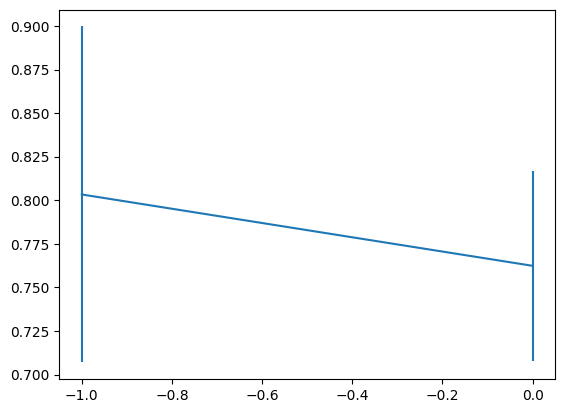

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(minimal_similarities, np.mean(maes, axis=1), xerr=0., yerr=np.var(maes, axis=1))
plt.show()

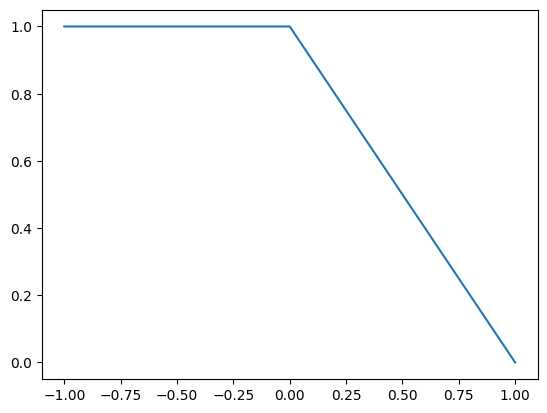

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(minimal_similarities, np.mean(coverages, axis=1), xerr=0., yerr=np.var(coverages, axis=1))
plt.show()

In [5]:
minimum_number_of_books_rated_in_common = 10

# Only use those which have an intersection of more than n books
my_books_read = uii_matrix.loc[my_user_id].notna()
intersections = uii_matrix.apply(lambda x: (x.notna() & my_books_read).sum(), axis=1)
similarities[intersections < minimum_number_of_books_rated_in_common] = np.nan

# Remove self similarity
similarities[my_user_id] = np.nan

In [6]:
minimal_similarity = 0.7
minimal_number_of_ratings = 5

def scoring(column):
    # Consider those users with at least a similarity of minimal_similarity
    neighbours = similarities > minimal_similarity
    # Calculate weighted mean of ratings as scores
    numerator = np.sum(column[neighbours]*similarities[neighbours])
    denominator = np.sum(similarities[neighbours][column[neighbours].notna()])
    predicted_rating = numerator/denominator if denominator != 0 else np.nan

    # If book has been rated less than minimal_number_of_ratings, set its score to nan
    if column[neighbours].notna().sum() <= minimal_number_of_ratings:
        predicted_rating = np.nan
    return predicted_rating

scores = uii_matrix.apply(lambda x: scoring(x))

# Print only recommendations of books I haven't read:
print(scores[~my_books_read].sort_values(ascending=False)[:10])

title
Lonesome Dove                                                                  4.884893
Ahab's Wife, or The Star-Gazer                                                 4.852697
Someone Knows My Name                                                          4.844823
The Diving Bell and the Butterfly                                              4.828780
The Nightingale                                                                4.821673
A Storm of Swords: Blood and Gold (A Song of Ice and Fire, #3: Part 2 of 2)    4.810564
The Power of One (The Power of One, #1)                                        4.778453
The Book of Mormon: Another Testament of Jesus Christ                          4.777642
The Complete Maus (Maus, #1-2)                                                 4.772905
Maus I: A Survivor's Tale: My Father Bleeds History (Maus, #1)                 4.745223
dtype: float64
